## Name: Shivkumar G. Chauhan
### Roll No.: CS8A53
### Batch A-3
---
# Applied Data Science

## imports

In [10]:
import pandas
import numpy
import warnings
import matplotlib.pyplot as pyplot

import scipy.stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import joblib
import datetime
from statsmodels.tsa.arima.model import ARIMA

## Configurations

In [11]:
StandardScaler=preprocessing.StandardScaler(
    with_mean=False,
    with_std=True
)
Normalizer=preprocessing.Normalizer(
    norm='max'
)

In [12]:
%matplotlib qt
# %matplotlib inline
# pyplot.rcParams["figure.figsize"] = (15, 12)

hiding warnings

In [12]:
warnings.filterwarnings('ignore')

Initializing Functions

In [14]:
def normalDistributionGraphGenarator(
    data:numpy.array,
    *ExtraArguments
)->None:
    """Normalization graph plotter function

    Args:
        data (numpy.array): Any Array or DataFrame Column
    """
    pyplot.figure('Normal Distribution Graph')
    data=numpy.sort(data)
    pyplot.plot(data, scipy.stats.norm.pdf(
        data, 
        numpy.mean(data),
        numpy.std(data))
    )
    for data in ExtraArguments:
        data=numpy.sort(data)
        pyplot.plot(data, 
            scipy.stats.norm.pdf(
            data, 
            numpy.mean(data),
            numpy.std(data))
    )
    pyplot.xlabel('values')
    pyplot.ylabel("Normalized Values")

In [15]:
def generateClusters(data:pandas.DataFrame,column_name:str,number_of_clusters=5)->list:
    """ Function for getting clusters using Kmeans Method
        Only Numerical Column is allowed

    Args:
        data (pandas.DataFrame): DataFrame Copy
        column_name (str): Specific Column Name
        number_of_clusters (int, optional): number of required clusters . Defaults to 5.

    Returns:
        list: list of DataFrames
    """
    Samples=[]
    column_data=data[column_name]
    cluster_centers,_=kmeans(
        column_data.to_numpy(),
        k_or_guess=number_of_clusters
    )
    cluster_indexes,_ = vq(
        column_data.to_numpy(),
        cluster_centers
    )
    data["cluster_value"]=cluster_indexes
    for i in range(number_of_clusters):
        Samples.append(
            data[data["cluster_value"]==i].sort_values(by=column_name,
                                                       ascending=False
    ).reset_index(
                drop=True
    ).drop(
        ['cluster_value'],axis=1)
    )
    data=data.drop(['cluster_value'],axis=1)
    return Samples

In [16]:
def PreprocessTheCovidData(Main_Data:pandas.DataFrame,Selected_columns:list,isCumulative=False)->pandas.DataFrame:
    """Final Function for Whole Data Processing for Covid Data

    Args:
        Main_Data (pandas.DataFrame): Initial Raw Data
        Selected_columns (list): list of columns that to bet selected

    Returns:
        pandas.DataFrame: Preprocessed Data
    """
    Main_Data=Main_Data[Selected_Columns]
    if isCumulative:
        for index in Main_Data['location'].value_counts().index:
            if len(Main_Data[Main_Data['location']==index]['total_cases'].unique())<2:
                Main_Data=Main_Data[Main_Data['location']!=index]
    for index in Main_Data[Main_Data['continent'].isnull()==True]['location'].value_counts().index:
        if index.find("income")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"Income Based"})
        elif index.find("Europe")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"Europe"})
        elif index.find("International")!=-1 or index.find("World")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"World"})
        else:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":index})
    for index in Main_Data[Main_Data['life_expectancy'].isnull()==False]['continent'].value_counts().index:
        Main_Data[Main_Data['continent']==index]=Main_Data[Main_Data['continent']==index].fillna(value={"life_expectancy":Main_Data[Main_Data['continent']==index]['life_expectancy'].mean()})
    Main_Data=Main_Data.fillna(value={"life_expectancy":Main_Data['life_expectancy'].mean()})
    Main_Data['population']=Main_Data['population'].fillna(Main_Data[Main_Data['location']=='International']['total_cases'].max())
    Main_Data[['new_cases','new_deaths']]=Main_Data[['new_cases','new_deaths']].fillna(0)
    for index in Main_Data['location'].value_counts().index:
        Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(0,limit=1)
        Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(method='ffill')
    return Main_Data

reading dataset

In [13]:
Raw_Data=pandas.read_csv("./Data/Raw_Data/owid-covid-data.csv",date_parser='date')

Sorting the Dataframe using total_cases column

selecting specific columns

In [14]:
Raw_Data=Raw_Data.sort_values(
    by="total_cases",
    ascending=False
).reset_index(drop=True)

In [15]:
Selected_Columns=['iso_code','date', 'continent', 'location', 'total_cases','new_cases', 'total_deaths', 'new_deaths','population','life_expectancy']

Location Specific Data

Recently Updated Data

In [16]:
location="India"

In [17]:
recent_date=Raw_Data['date'][0]
Recent_Data=Raw_Data[Raw_Data['date']==recent_date]

In [18]:
Location_Specific_Data=Raw_Data[
    Raw_Data['location']==location
]

# Data Exploration

## Raw Data

printing Checking of Raw dataset

In [23]:
Raw_Data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,OWID_WRL,NaN,World,2023-03-21,761071062.0,33950.0,93977.286,6879664.0,198.0,619.714,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
1,OWID_WRL,NaN,World,2023-03-20,761037112.0,54418.0,101009.857,6879466.0,256.0,668.857,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
2,OWID_WRL,NaN,World,2023-03-19,760982694.0,80448.0,104900.286,6879210.0,325.0,699.571,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
3,OWID_WRL,NaN,World,2023-03-18,760902246.0,216329.0,117118.286,6878885.0,2478.0,781.286,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
4,OWID_WRL,NaN,World,2023-03-17,760685917.0,76049.0,124941.857,6876407.0,294.0,799.571,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN


printing different statistics of dataset like mean, quantiles, min, max etc.

In [24]:
Raw_Data.describe(include="all")

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,297152,283021,297152,297152,2.614010e+05,2.886750e+05,2.874110e+05,2.409870e+05,288741.000000,287511.000000,...,170354.000000,112729.000000,203231.000000,273235.000000,223159.000000,2.971520e+05,1.020500e+04,10205.000000,10205.000000,10205.000000
unique,255,6,255,1181,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ARG,Africa,Argentina,2022-04-20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1180,66919,1180,255,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,5.367080e+06,1.117552e+04,1.122060e+04,7.798592e+04,99.555030,99.947194,...,32.911114,50.794994,3.098023,73.721018,0.722548,1.283638e+08,4.683279e+04,9.488196,13.073035,1437.715461
std,NaN,NaN,NaN,NaN,3.374066e+07,1.052843e+05,1.025490e+05,4.045377e+05,612.409212,602.917596,...,13.572942,31.957226,2.548891,7.397070,0.148996,6.605372e+08,1.371560e+05,13.099374,26.692084,1822.875623
min,NaN,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,...,7.700000,1.188000,0.100000,53.280000,0.394000,4.700000e+01,-3.772610e+04,-44.230000,-95.920000,-1984.281600
25%,NaN,NaN,NaN,NaN,5.999000e+03,0.000000e+00,1.286000e+00,1.160000e+02,0.000000,0.000000,...,22.600000,20.859000,1.300000,69.590000,0.602000,4.490020e+05,1.930000e+01,0.370000,-0.990000,12.528376
50%,NaN,NaN,NaN,NaN,5.800800e+04,2.100000e+01,4.142900e+01,1.163000e+03,0.000000,0.286000,...,33.100000,49.839000,2.500000,75.050000,0.740000,5.882259e+06,4.342600e+03,7.690000,6.800000,863.340940
75%,NaN,NaN,NaN,NaN,5.985810e+05,5.800000e+02,6.674290e+02,1.015950e+04,6.000000,7.143000,...,41.300000,83.241000,4.200000,79.460000,0.829000,2.830170e+07,3.104800e+04,15.460000,18.620000,2344.063000


printing the dataset information like column values counts, column value data type

In [25]:
Raw_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297152 entries, 0 to 297151
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    297152 non-null  object 
 1   continent                                   283021 non-null  object 
 2   location                                    297152 non-null  object 
 3   date                                        297152 non-null  object 
 4   total_cases                                 261401 non-null  float64
 5   new_cases                                   288675 non-null  float64
 6   new_cases_smoothed                          287411 non-null  float64
 7   total_deaths                                240987 non-null  float64
 8   new_deaths                                  288741 non-null  float64
 9   new_deaths_smoothed                         287511 non-null  float64
 

## Location Specific Data

Printing Location Specific Data

In [26]:
Location_Specific_Data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
6470,IND,Asia,India,2023-03-21,44696984.0,646.0,806.571,530808.0,2.0,3.429,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6471,IND,Asia,India,2023-03-20,44696338.0,918.0,771.714,530806.0,4.0,3.429,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6472,IND,Asia,India,2023-03-19,44695420.0,1071.0,704.000,530802.0,3.0,3.000,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6473,IND,Asia,India,2023-03-18,44694349.0,843.0,625.857,530799.0,4.0,2.714,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6474,IND,Asia,India,2023-03-17,44693506.0,796.0,570.571,530795.0,5.0,2.286,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN


printing different statistics of dataset like mean, quantiles, min, max etc.

In [27]:
Location_Specific_Data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.147000e+03,1171.000000,1166.000000,1104.000000,1174.000000,1169.000000,1147.000000,1171.000000,1166.000000,1104.000000,...,1.179000e+03,1.179000e+03,1.179000e+03,1.179000e+03,1.179000e+03,1.179000e+03,0.0,0.0,0.0,0.0
mean,2.582627e+07,38170.570453,38331.506116,335841.667572,452.136286,454.061965,18223.793786,26.934286,27.047864,236.979976,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
std,1.755011e+07,71005.505886,70558.344671,202971.144119,806.654970,775.305346,12383.887300,50.103628,49.788082,143.222546,...,7.108443e-15,1.421689e-14,2.221388e-16,2.843377e-14,1.110694e-16,0.000000e+00,NaN,NaN,NaN,NaN
min,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.001000,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
25%,8.659964e+06,1769.500000,1896.928750,143271.000000,17.000000,21.714000,6110.730500,1.249000,1.338750,101.096750,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
50%,3.251237e+07,13052.000000,13295.643000,443712.500000,161.500000,209.143000,22941.704000,9.210000,9.381500,313.097000,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
75%,4.318767e+07,41258.500000,40619.714500,524843.750000,505.500000,518.286000,30474.516500,29.113000,28.662500,370.345500,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
max,4.469698e+07,414188.000000,391279.571000,530808.000000,6148.000000,4190.000000,31539.537000,292.264000,276.099000,374.554000,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN


## Recently Updated Data

Printing Recently Updated Data

In [28]:
Recent_Data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,OWID_WRL,NaN,World,2023-03-21,761071062.0,33950.0,93977.286,6879664.0,198.0,619.714,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
398,OWID_HIC,NaN,High income,2023-03-21,417910867.0,20591.0,67340.143,2837386.0,126.0,487.429,...,NaN,NaN,NaN,NaN,NaN,1.250515e+09,NaN,NaN,NaN,NaN
763,OWID_ASI,NaN,Asia,2023-03-21,295265312.0,3593.0,25724.714,1626572.0,27.0,118.286,...,NaN,NaN,NaN,NaN,NaN,4.721383e+09,NaN,NaN,NaN,NaN
967,OWID_EUR,NaN,Europe,2023-03-21,247480240.0,27553.0,39705.143,2029529.0,154.0,188.286,...,NaN,NaN,NaN,NaN,NaN,7.448078e+08,NaN,NaN,NaN,NaN
1068,OWID_UMC,NaN,Upper middle income,2023-03-21,242747582.0,11000.0,24040.714,2651676.0,45.0,98.429,...,NaN,NaN,NaN,NaN,NaN,2.525921e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274299,MAC,Asia,Macao,2023-03-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,84.24,NaN,6.951800e+05,NaN,NaN,NaN,NaN
280051,PRK,Asia,North Korea,2023-03-21,NaN,0.0,0.000,NaN,0.0,0.000,...,NaN,NaN,13.200,72.27,NaN,2.606942e+07,NaN,NaN,NaN,NaN
281912,OWID_NIR,Europe,Northern Ireland,2023-03-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.896000e+06,NaN,NaN,NaN,NaN
290200,TWN,Asia,Taiwan,2023-03-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,80.46,NaN,2.389340e+07,NaN,NaN,NaN,NaN


printing different statistics of dataset like mean, quantiles, min, max etc.

In [29]:
Recent_Data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,2.440000e+02,218.000000,218.000000,2.370000e+02,232.000000,232.000000,244.000000,218.000000,218.000000,237.000000,...,145.000000,96.000000,173.000000,232.00000,189.000000,2.500000e+02,0.0,0.0,0.0,0.0
mean,1.322130e+07,701.311927,1608.395794,1.212382e+05,3.900862,9.437216,199236.108311,9.845257,16.094633,1287.114675,...,32.909897,50.788844,3.097012,73.68750,0.721302,1.294986e+08,NaN,NaN,NaN,NaN
std,6.458998e+07,3612.253639,8872.086479,5.677230e+05,20.519099,57.527869,194426.138220,39.843061,52.716933,1279.332907,...,13.621757,32.124848,2.555777,7.39921,0.148876,6.644997e+08,NaN,NaN,NaN,NaN
min,4.000000e+00,0.000000,0.000000,1.000000e+00,0.000000,0.000000,354.487000,0.000000,0.000000,1.164000,...,7.700000,1.188000,0.100000,53.28000,0.394000,4.700000e+01,NaN,NaN,NaN,NaN
25%,2.783275e+04,0.000000,0.000000,2.590000e+02,0.000000,0.000000,24063.459500,0.000000,0.000000,191.208000,...,22.600000,20.482000,1.300000,69.56750,0.602000,4.677010e+05,NaN,NaN,NaN,NaN
50%,2.424370e+05,0.000000,0.000000,2.795000e+03,0.000000,0.000000,135324.783000,0.000000,0.000000,945.525000,...,33.100000,49.690500,2.500000,75.05000,0.740000,5.926344e+06,NaN,NaN,NaN,NaN
75%,1.715720e+06,0.000000,8.071500,1.988000e+04,0.000000,0.143000,331699.877500,0.000000,3.453250,2036.568000,...,41.300000,82.686750,4.200000,79.40000,0.828000,2.928421e+07,NaN,NaN,NaN,NaN
max,7.610711e+08,33950.000000,93977.286000,6.879664e+06,198.000000,619.714000,729533.363000,335.874000,429.629000,6450.827000,...,78.100000,100.000000,13.800000,86.75000,0.957000,7.975105e+09,NaN,NaN,NaN,NaN


In [30]:
Recent_Data.copy().reset_index()

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,0,OWID_WRL,NaN,World,2023-03-21,761071062.0,33950.0,93977.286,6879664.0,198.0,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
1,398,OWID_HIC,NaN,High income,2023-03-21,417910867.0,20591.0,67340.143,2837386.0,126.0,...,NaN,NaN,NaN,NaN,NaN,1.250515e+09,NaN,NaN,NaN,NaN
2,763,OWID_ASI,NaN,Asia,2023-03-21,295265312.0,3593.0,25724.714,1626572.0,27.0,...,NaN,NaN,NaN,NaN,NaN,4.721383e+09,NaN,NaN,NaN,NaN
3,967,OWID_EUR,NaN,Europe,2023-03-21,247480240.0,27553.0,39705.143,2029529.0,154.0,...,NaN,NaN,NaN,NaN,NaN,7.448078e+08,NaN,NaN,NaN,NaN
4,1068,OWID_UMC,NaN,Upper middle income,2023-03-21,242747582.0,11000.0,24040.714,2651676.0,45.0,...,NaN,NaN,NaN,NaN,NaN,2.525921e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,274299,MAC,Asia,Macao,2023-03-21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,84.24,NaN,6.951800e+05,NaN,NaN,NaN,NaN
246,280051,PRK,Asia,North Korea,2023-03-21,NaN,0.0,0.000,NaN,0.0,...,NaN,NaN,13.200,72.27,NaN,2.606942e+07,NaN,NaN,NaN,NaN
247,281912,OWID_NIR,Europe,Northern Ireland,2023-03-21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.896000e+06,NaN,NaN,NaN,NaN
248,290200,TWN,Asia,Taiwan,2023-03-21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,80.46,NaN,2.389340e+07,NaN,NaN,NaN,NaN


# Data Preprocessing

In [31]:
Main_Data=PreprocessTheCovidData(
    Location_Specific_Data.copy().sort_values(by='date',ascending=True).reset_index(drop=True),
    Selected_Columns
)

In [32]:
Main_Data

,iso_code,date,continent,location,total_cases,new_cases,total_deaths,new_deaths,population,life_expectancy
0,IND,2020-01-03,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
1,IND,2020-01-04,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
2,IND,2020-01-05,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
3,IND,2020-01-06,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
4,IND,2020-01-07,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
...,...,...,...,...,...,...,...,...,...,...
1174,IND,2023-03-22,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66
1175,IND,2023-03-23,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66
1176,IND,2023-03-24,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66
1177,IND,2023-03-25,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66


# Data Visualization

##### Normalization Graphs Plotter

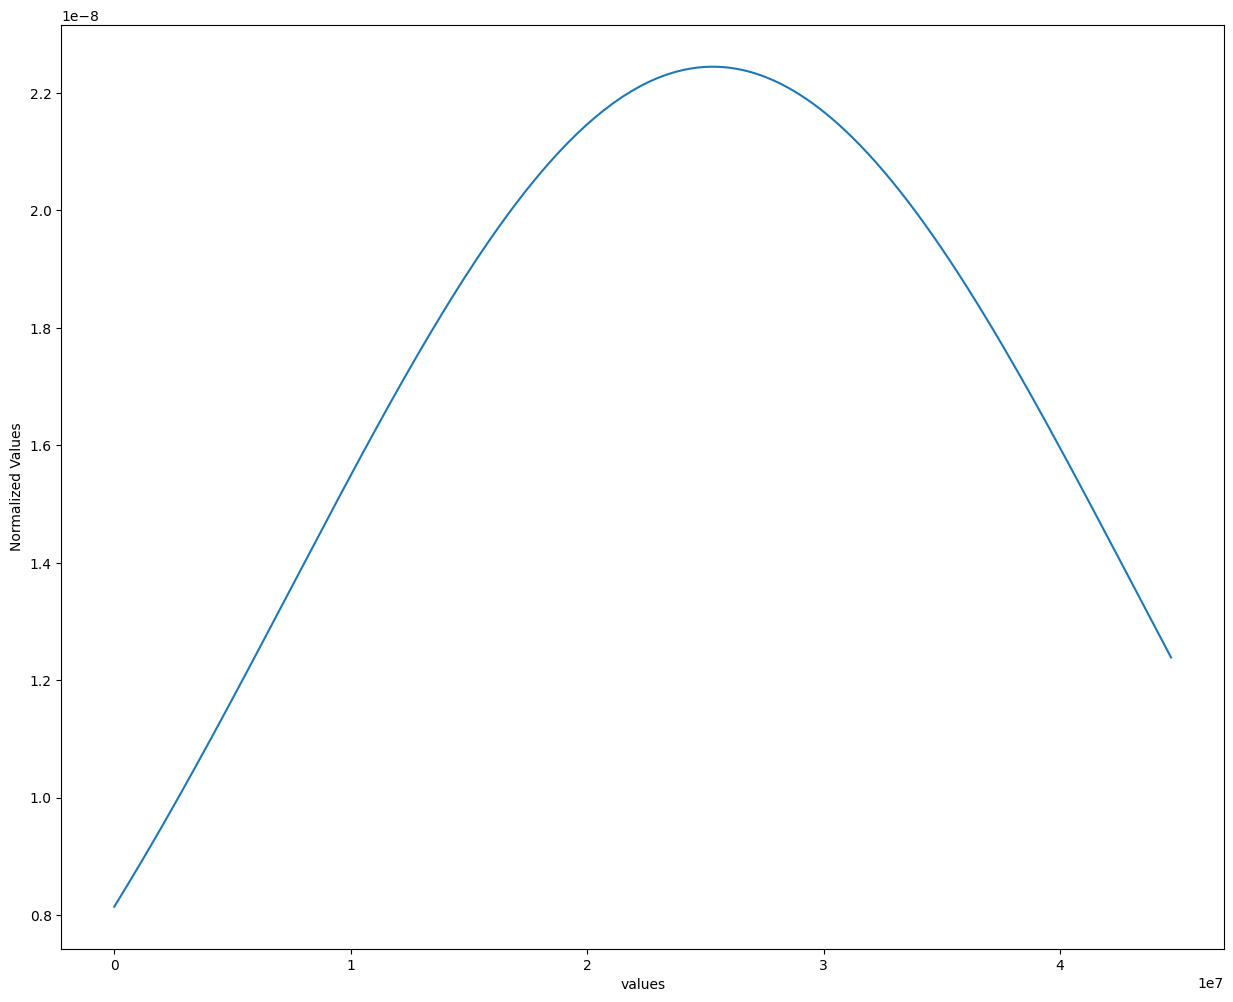

In [31]:
normalDistributionGraphGenarator(Main_Data['total_cases'])

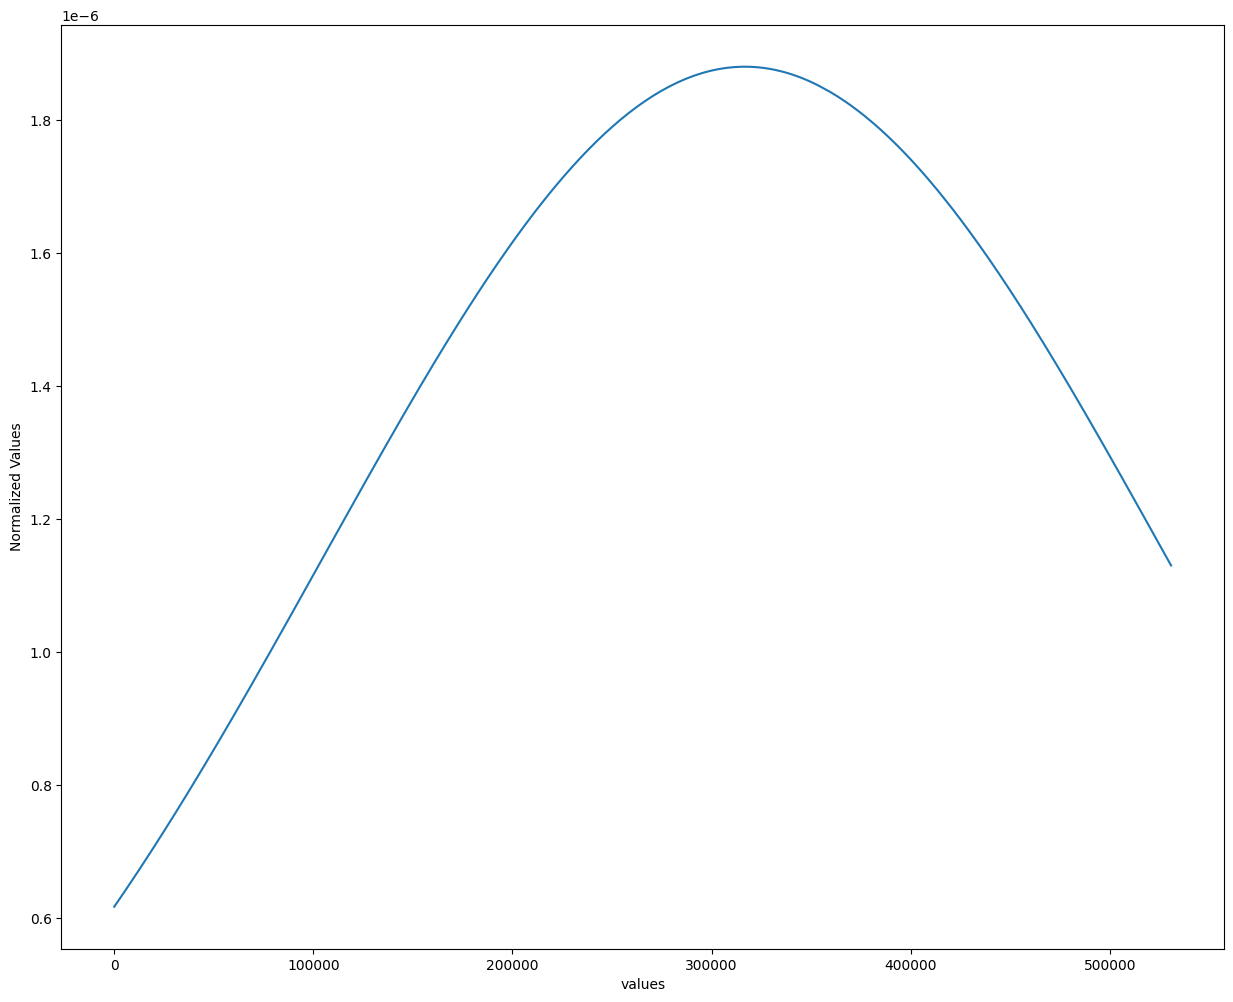

In [32]:
normalDistributionGraphGenarator(Main_Data['total_deaths'])

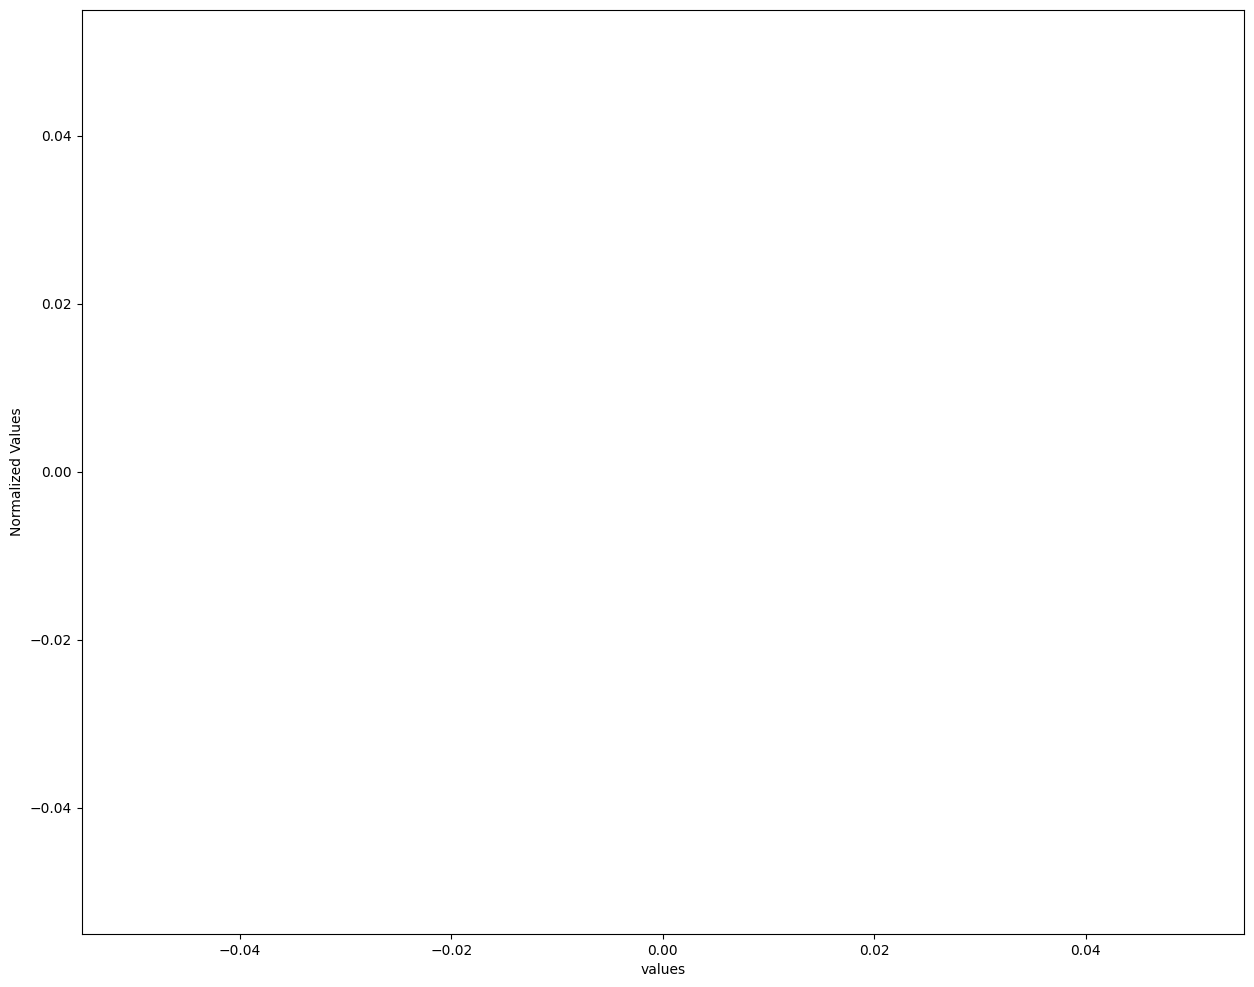

In [34]:
normalDistributionGraphGenarator(Main_Data['population'])

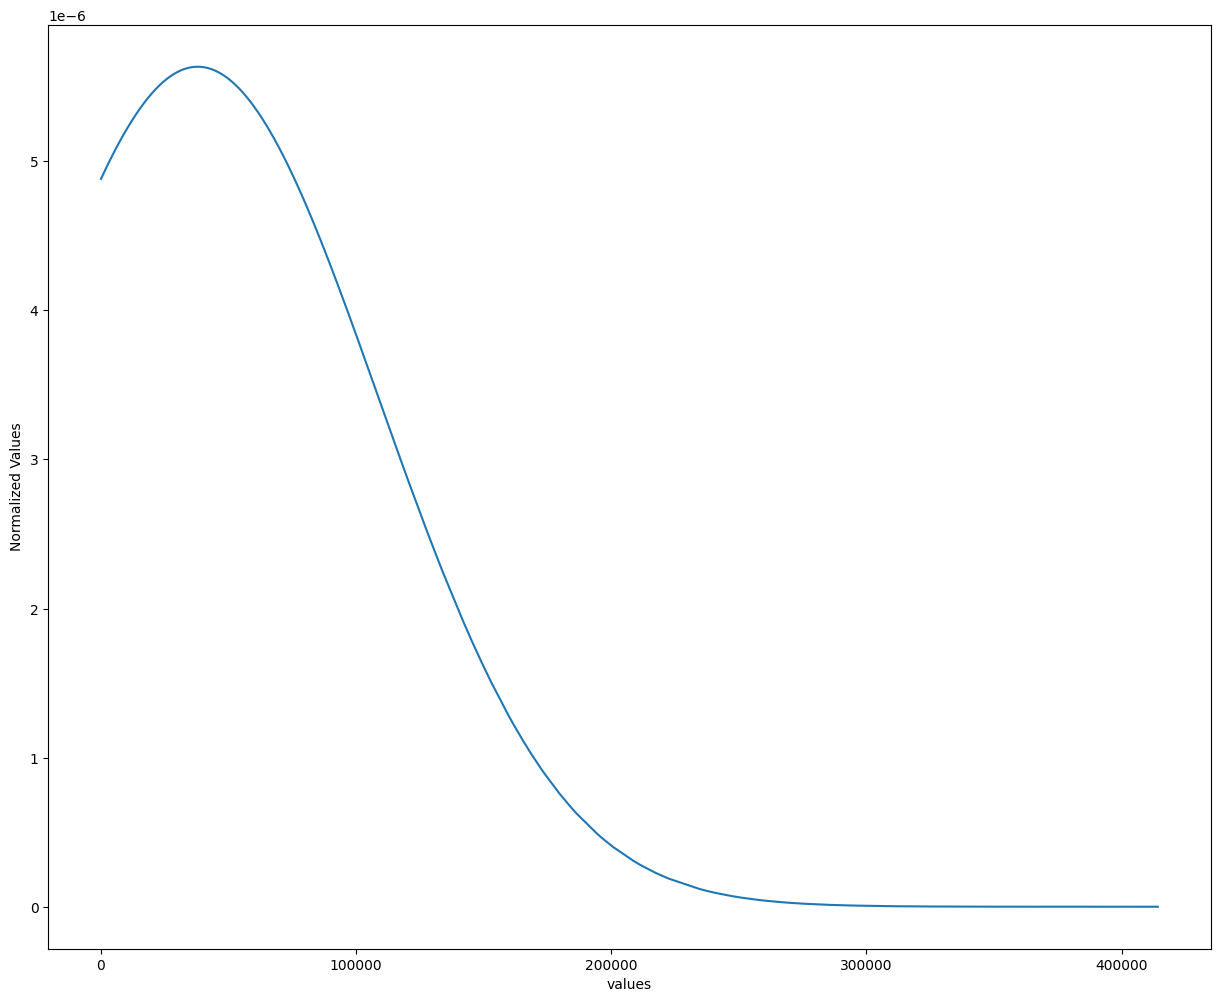

In [33]:
normalDistributionGraphGenarator(Main_Data['new_cases'])

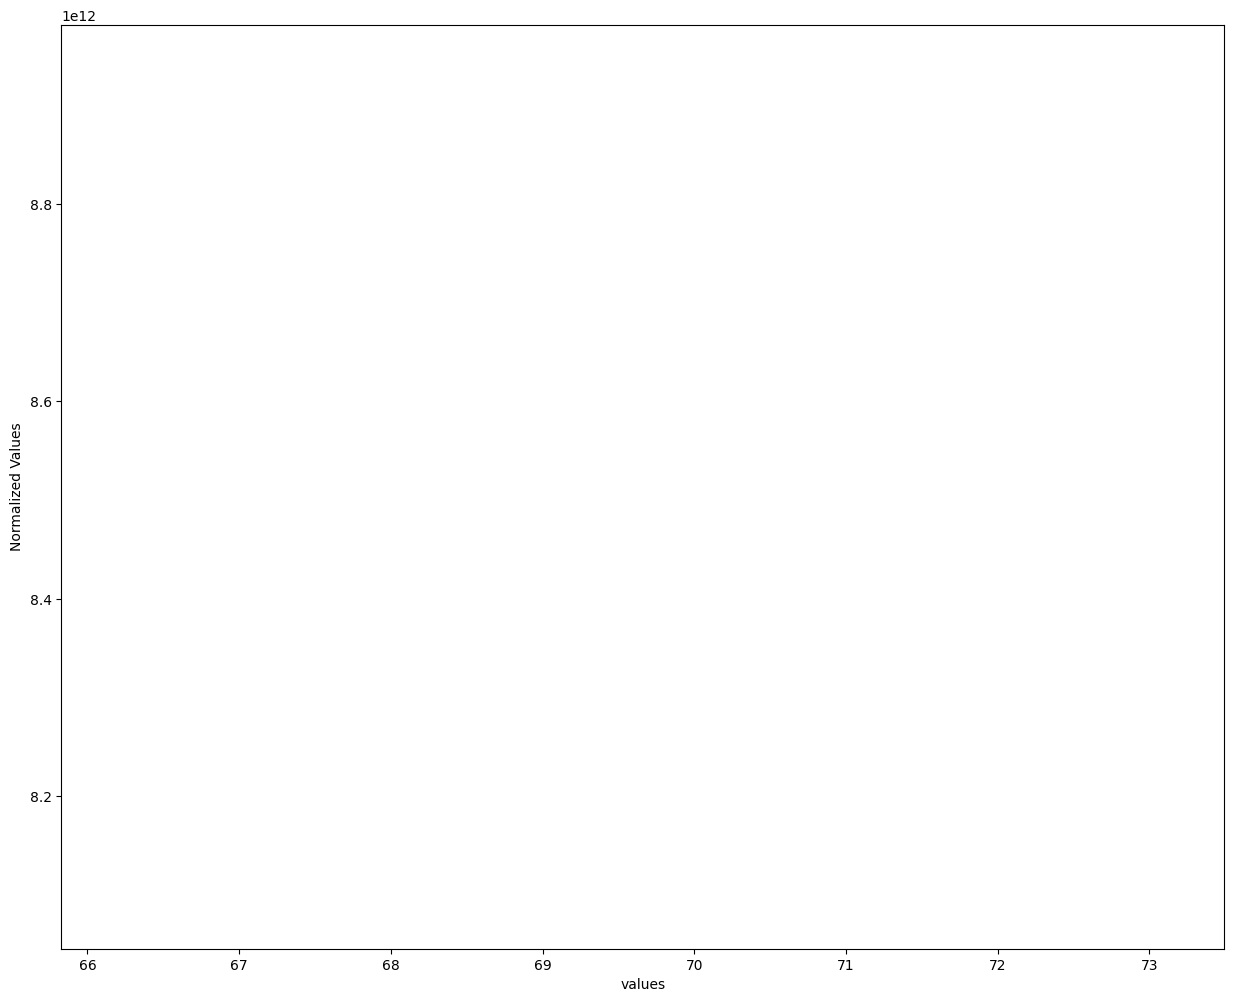

In [36]:
normalDistributionGraphGenarator(Main_Data['life_expectancy'])

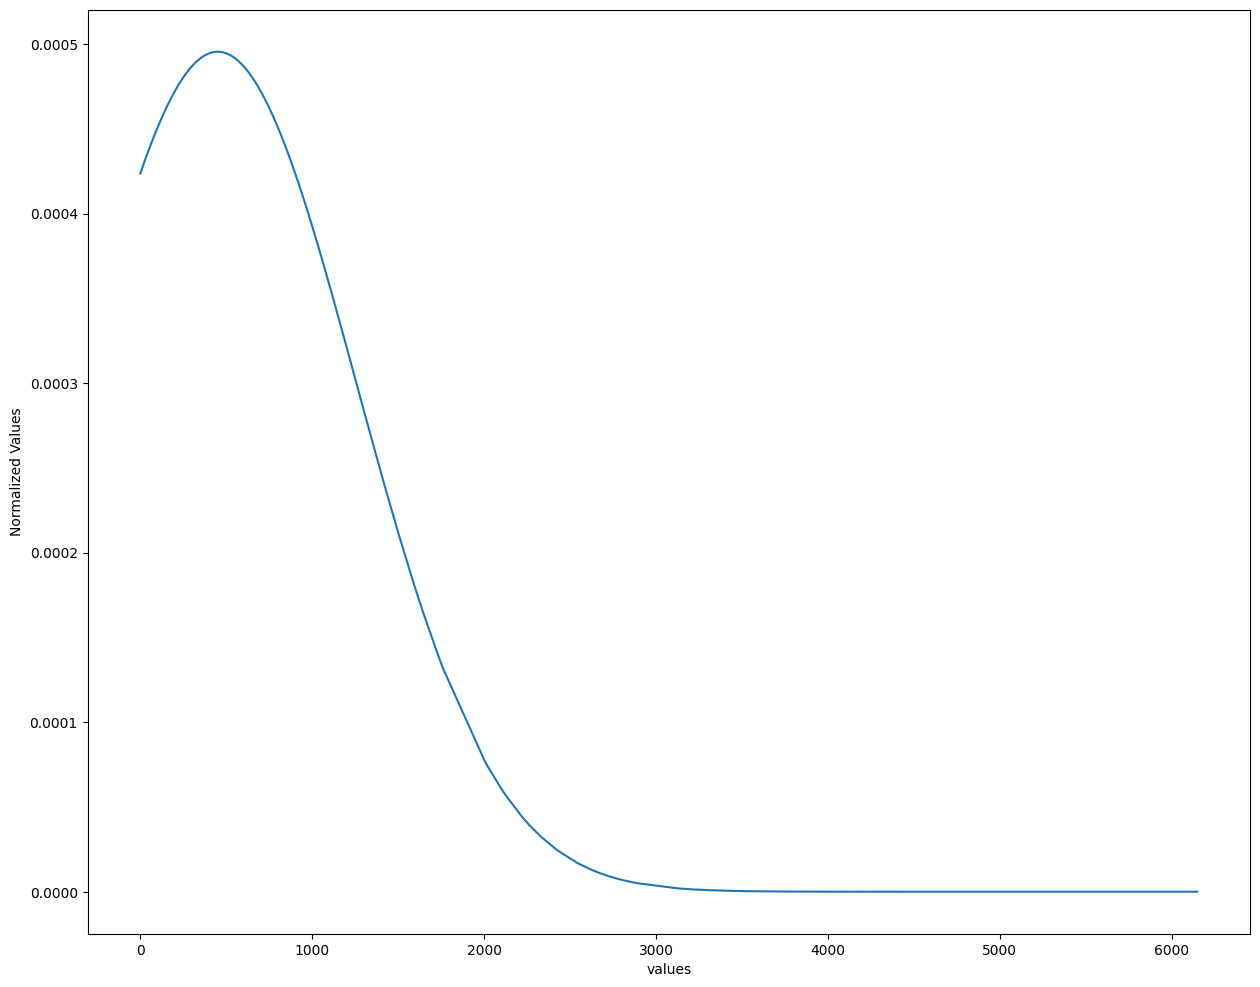

In [35]:
normalDistributionGraphGenarator(Main_Data['new_deaths'])

In [45]:
Labels=Main_Data['new_cases']

In [46]:
Main_Data.columns

Index(['iso_code', 'date', 'continent', 'location', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'population', 'life_expectancy'],
      dtype='object')

In [47]:
Training_limit=int(len(Main_Data)*0.8)
Testing_Fetures=Main_Data[Training_limit:]
Testing_Labels=Labels[Training_limit:]
Training_Features=Main_Data[:Training_limit]
Training_Labels=Labels[:Training_limit]

In [48]:
linear_regression_model=LinearRegression()
random_forest_model=RandomForestRegressor()
decision_tree_model=DecisionTreeRegressor()

In [42]:
number_of_next_days=7
def returnNextdays():
    date=738094
    date_range=[]
    l=[]
    for i in range(1,number_of_next_days+1):
        l.append([date+i])
        date_range.append(datetime.date.fromordinal(date+i))
    return l,date_range
predictingdate,daterange=returnNextdays()

In [78]:
Training_Indexes=Training_Features.index
pandas.DataFrame(numpy.array(Training_Indexes))
Testing_Indexes=Testing_Fetures.index
pandas.DataFrame(numpy.array(Testing_Indexes))

,0
0,943
1,944
2,945
3,946
4,947
...,...
231,1174
232,1175
233,1176
234,1177


In [49]:
daterange=[[i] for i in range(len(Main_Data),len(Main_Data)+7)]

## Simple Linear Regression

In [76]:
def ApplyModelAndEValuate(Model_Name,Model):
    Model.fit(pandas.DataFrame(numpy.array(Training_Indexes)),Training_Labels)
    linear_regression_model_train_predicted=Model.predict(pandas.DataFrame(numpy.array(Training_Indexes)))
    linear_regression_model_test_predicted=Model.predict(pandas.DataFrame(numpy.array(Testing_Indexes)))
    linear_regression_model_next_days_predicted=Model.predict(daterange)
    pyplot.figure(Model_Name)
    line_of_regression=numpy.concatenate((linear_regression_model_train_predicted,linear_regression_model_test_predicted))
    pyplot.plot(Main_Data['date'],Labels,label='Original Data')
    pyplot.plot(Main_Data['date'],line_of_regression,label='Line of Regression')
    pyplot.plot(Training_Features['date'],linear_regression_model_train_predicted,label='Train Data')
    pyplot.plot(Testing_Fetures['date'],linear_regression_model_test_predicted,label='Test Data')
    pyplot.plot(daterange,linear_regression_model_next_days_predicted,label='Future Prediction')
    pyplot.xlabel('Date')
    pyplot.legend()
    pyplot.show()
    print(Model_Name)
    print("Trainig MAE: ",mean_absolute_error(linear_regression_model_train_predicted,Training_Labels),"\nTraining RMSE:",numpy.sqrt(mean_squared_error(linear_regression_model_train_predicted,Training_Labels)))
    print()
    print("Testing MAE:",mean_absolute_error(linear_regression_model_test_predicted,Testing_Labels),"\nTesting RMSE:",numpy.sqrt(mean_squared_error(linear_regression_model_test_predicted,Testing_Labels)))

In [74]:
linear_regression_model.fit(pandas.DataFrame(numpy.array(Indexes)),Training_Labels)

NameError: name 'Indexes' is not defined

In [ ]:
linear_regression_model_train_predicted=linear_regression_model.predict(pandas.DataFrame(numpy.array(Indexes)))

In [66]:
linear_regression_model_test_predicted=linear_regression_model.predict(pandas.DataFrame(numpy.array(Testing_Indexes)))

In [79]:
linear_regression_model_next_days_predicted=linear_regression_model.predict(daterange)

In [80]:
pyplot.figure('linear regression')
line_of_regression=numpy.concatenate((linear_regression_model_train_predicted,linear_regression_model_test_predicted))
pyplot.plot(Main_Data['date'],Labels,label='Original Data')
pyplot.plot(Main_Data['date'],line_of_regression,label='Line of Regression')
pyplot.plot(Training_Features['date'],linear_regression_model_train_predicted,label='Train Data')
pyplot.plot(Testing_Fetures['date'],linear_regression_model_test_predicted,label='Test Data')
pyplot.plot(daterange,linear_regression_model_next_days_predicted,label='Future Prediction')
pyplot.xlabel('Date')
pyplot.legend()
pyplot.show()

In [89]:
print('Model Name')
print("Trainig MAE: ",mean_absolute_error(linear_regression_model_train_predicted,Training_Labels),"\nTraining RMSE:",numpy.sqrt(mean_squared_error(linear_regression_model_train_predicted,Training_Labels)))
print()
print("Testing MAE:",mean_absolute_error(linear_regression_model_test_predicted,Testing_Labels),"\nTesting RMSE:",numpy.sqrt(mean_squared_error(linear_regression_model_test_predicted,Testing_Labels)))

Model Name
Trainig MAE:  47399.47270253046 
Training RMSE: 76438.91106873097

Testing MAE: 56381.546351998615 
Testing RMSE: 56660.83822335304


In [79]:
ApplyModelAndEValuate("Linear Regression",LinearRegression())

Linear Regression
Trainig MAE:  47399.47270253046 
Training RMSE: 76438.91106873097

Testing MAE: 56381.546351998615 
Testing RMSE: 56660.83822335304


## Random Forest Regression

In [80]:
ApplyModelAndEValuate("Random Forest Regression",RandomForestRegressor())

Random Forest Regression
Trainig MAE:  1031.4904984093318 
Training RMSE: 2126.4245088050675

Testing MAE: 12743.886271186442 
Testing RMSE: 13309.633840607998


## Polynomial Regression

In [104]:
def polynomial_regrassion_model(degree_of_equation=1):
    polynomial=PolynomialFeatures(degree=degree_of_equation)
    polynomial_train_data=polynomial.fit_transform(pandas.DataFrame(numpy.array(Training_Indexes)).to_numpy())
    polynomial_test_data=polynomial.fit_transform(pandas.DataFrame(numpy.array(Testing_Indexes)).to_numpy())
    polynomial_future_test_data=polynomial.fit_transform(daterange)
    polynomial_regression=LinearRegression()
    polynomial_regression.fit(polynomial_train_data,Training_Labels)
    polynomial_regression_model_train_predicted=polynomial_regression.predict(polynomial_train_data)
    polynomial_regression_model_test_predicted=polynomial_regression.predict(polynomial_test_data)
    polynomial_regression_model_next_days_predicted=polynomial_regression.predict(polynomial_future_test_data)
#     print('Train Data Prediction')
#     print(polynomial_regression_model_train_predicted)
#     print('\n\n\nTest Data Prediction')
#     print(polynomial_regression_model_test_predicted)
#     print('\n\n\nFuture Data Prediction')
#     print(polynomial_regression_model_next_days_predicted)
#     print('\n\n\n')
    print('{} degree Polynomial regression'.format(degree_of_equation))
    print(mean_absolute_error(polynomial_regression_model_train_predicted,Training_Labels),numpy.sqrt(mean_squared_error(polynomial_regression_model_train_predicted,Training_Labels)))
    print(mean_absolute_error(polynomial_regression_model_test_predicted,Testing_Labels),numpy.sqrt(mean_squared_error(polynomial_regression_model_test_predicted,Testing_Labels)))
    pyplot.figure('{} degree Polynomial regression'.format(degree_of_equation))
    pyplot.plot(Main_Data['date'],Labels,label='Original Data')
    pyplot.plot(Training_Features['date'],polynomial_regression_model_train_predicted,label='Train Data')
    pyplot.plot(Testing_Fetures['date'],polynomial_regression_model_test_predicted,label='Test Data')
    pyplot.plot(daterange,polynomial_regression_model_next_days_predicted,label='Future Prediction')
    pyplot.xlabel('Date')
    pyplot.show()

In [113]:
def polynomial_regrassion_model(degree_of_equation=1):
    polynomial=PolynomialFeatures(degree=degree_of_equation)
    polynomial_train_data=polynomial.fit_transform(pandas.DataFrame(numpy.array(Training_Indexes)).to_numpy())
    polynomial_test_data=polynomial.fit_transform(pandas.DataFrame(numpy.array(Testing_Indexes)).to_numpy())
    polynomial_future_test_data=polynomial.fit_transform(daterange)
    polynomial_regression=LinearRegression()
    polynomial_regression.fit(polynomial_train_data,Training_Labels)
    polynomial_regression_model_train_predicted=polynomial_regression.predict(polynomial_train_data)
    polynomial_regression_model_test_predicted=polynomial_regression.predict(polynomial_test_data)
    polynomial_regression_model_next_days_predicted=polynomial_regression.predict(polynomial_future_test_data)
    print('{} degree Polynomial regression'.format(degree_of_equation)) print(mean_absolute_error(polynomial_regression_model_train_predicted,Training_Labels),numpy.sqrt(mean_squared_error(polynomial_regression_model_train_predicted,Training_Labels)))
    print(mean_absolute_error(polynomial_regression_model_test_predicted,Testing_Labels),numpy.sqrt(mean_squared_error(polynomial_regression_model_test_predicted,Testing_Labels)))
    pyplot.figure('{} degree Polynomial regression'.format(degree_of_equation))
    pyplot.plot(Main_Data['date'],Labels,label='Original Data')
    pyplot.plot(Training_Features['date'],polynomial_regression_model_train_predicted,label='Train Data')
    pyplot.plot(Testing_Fetures['date'],polynomial_regression_model_test_predicted,label='Test Data')
    pyplot.plot(daterange,polynomial_regression_model_next_days_predicted,label='Future Prediction')
    pyplot.xlabel('Date')
    pyplot.legend()
    pyplot.show()

In [116]:
polynomial_regrassion_model(2)

2 degree Polynomial regression
43622.576300617075 70673.0679846496
65795.18753438337 72676.59378568902


In [117]:
polynomial_regrassion_model(3)

3 degree Polynomial regression
43733.35816577542 70653.85938133737
79772.24919295895 88105.53944262827


In [118]:
polynomial_regrassion_model(4)

4 degree Polynomial regression
41437.17722370892 70076.67896498552
82285.60865250726 104514.15897105791


In [119]:
polynomial_regrassion_model(5)

5 degree Polynomial regression
41433.10793368236 70076.62916204361
85595.91188637729 108718.54645423924


In [128]:
Main_Data['index']=Main_Data.index

## ARIMA

In [52]:
order_of_forecasting_models1=(5,0,3)
order_of_forecasting_models2=(3,0,3)
forcasting_data_features=Main_Data[['date','new_cases']]
forcasting_train_data_features=Main_Data[['date','new_cases']][:Training_limit]
forcasting_test_data_features=Main_Data[['date','new_cases']][Training_limit:]

In [53]:
forcasting_data_features['date']=pandas.to_datetime(forcasting_data_features['date'])
forcasting_train_data_features['date']=pandas.to_datetime(forcasting_train_data_features['date'])
forcasting_test_data_features['date']=pandas.to_datetime(forcasting_test_data_features['date'])
forcasting_data_features=forcasting_data_features.set_index('date')
forcasting_train_data_features=forcasting_train_data_features.set_index('date')
forcasting_test_data_features=forcasting_test_data_features.set_index('date')

In [54]:
main_arima_model = ARIMA(forcasting_data_features,order=order_of_forecasting_models1)
train_arima_model = ARIMA(forcasting_train_data_features,order=order_of_forecasting_models1)

In [55]:
main_arima_fit_model=main_arima_model.fit()
train_arima_fit_model=train_arima_model.fit()

In [60]:
main_arima_fit_model_predicted=main_arima_fit_model.predict()
train_arima_fit_model_predicted=train_arima_fit_model.predict()
test_arima_predicted=train_arima_fit_model.forecast(steps=len(forcasting_test_data_features))
arima_model_forcast=main_arima_fit_model.forecast(steps=7)

In [65]:
pyplot.figure('ARIMA model Forcasting')
pyplot.plot(Main_Data['date'],Labels,label='Original Data')
pyplot.plot(Training_Features['date'],train_arima_fit_model_predicted,label='Train Data')
pyplot.plot(Testing_Fetures['date'],test_arima_predicted,label='Test Data')
pyplot.plot(daterange,arima_model_forcast,label='ARIMA Future Prediction')
pyplot.xlabel('Date')
pyplot.ylabel('new_cases')
pyplot.legend()
pyplot.show()
print("Trainig MAE: ",mean_absolute_error(train_arima_fit_model_predicted,train_labels),"\nTraining RMSE:",numpy.sqrt(mean_squared_error(train_arima_fit_model_predicted,train_labels)))
print("Testing MAE:",mean_absolute_error(test_arima_predicted,test_labels),"\nTesting RMSE:",,numpy.sqrt(mean_squared_error(test_arima_predicted,test_labels)))

SyntaxError: invalid syntax (82189231.py, line 11)

In [72]:
pyplot.figure('ARIMA model Forcasting')
pyplot.plot(Main_Data['date'],Labels,label='Original Data')
pyplot.plot(Training_Features['date'],train_arima_fit_model_predicted,label='Train Data')
pyplot.plot(Testing_Fetures['date'],test_arima_predicted,label='Test Data')
pyplot.plot(daterange,arima_model_forcast,label='ARIMA Future Prediction')
pyplot.xlabel('Date')
pyplot.ylabel('new_cases')
pyplot.legend()
pyplot.show()
print("ARIMA Forecasting")
print("Trainig MAE: ",mean_absolute_error(train_arima_fit_model_predicted,Training_Labels),"\nTraining RMSE:",numpy.sqrt(mean_squared_error(train_arima_fit_model_predicted,Training_Labels)))
print("Testing MAE:",mean_absolute_error(test_arima_predicted,Testing_Labels),"\nTesting RMSE:",numpy.sqrt(mean_squared_error(test_arima_predicted,Testing_Labels)))

ARIMA Forecasting
Trainig MAE:  3265.5015714622905 
Training RMSE: 6435.118972399677
Testing MAE: 32420.09961468613 
Testing RMSE: 34676.78150587533
